# INF792 FINAL ASSIGNMENT

**Authors:** Paula Gribrini (matrícula), Sabrina Correa (es72145) <br>
**Creation:** 09 Dec. 2024 <br>
**Last modified:** 10 Dec. 2024 <br>
**Description:** This code replicates a Visual Transformer (ViT) model for better understanding of its workflow as part of the unit INF792 for the Federal University of Vicosa. It used the Flowers Dataset for training



**References:**
- https://arxiv.org/pdf/2010.11929
- https://www.learnpytorch.io/08_pytorch_paper_replicating/#what-is-paper-replicating




## 1. Importing libraries and datasets

The most important library to be used is <code>PyTorch</code>. From this library we can easily create Artificial Intelligence models

In [33]:
import os
from pathlib import Path

import numpy as np
import torch

import torch.nn as nn
import torchvision

import matplotlib.pyplot as plt

In [3]:
try:
    from torchinfo import summary
except:
    print("[INFO] Couldn't find torchinfo... installing it.")
    !pip install -q torchinfo
    from torchinfo import summary

In [6]:
# Try to import the going_modular directory, download it from GitHub if it doesn't work
# https://github.com/mrdbourke/pytorch-deep-learning/tree/main/going_modular
try:
    from going_modular.going_modular import data_setup, engine
    from helper_functions import download_data, set_seeds, plot_loss_curves
except:
    # Get the going_modular scripts
    print("[INFO] Couldn't find going_modular or helper_functions scripts... downloading them from GitHub.")
    !git clone https://github.com/mrdbourke/pytorch-deep-learning
    !mv pytorch-deep-learning/going_modular .
    !mv pytorch-deep-learning/helper_functions.py . # get the helper_functions.py script
    !rm -rf pytorch-deep-learning
    from going_modular.going_modular import data_setup, engine
    from helper_functions import download_data, set_seeds, plot_loss_curves

Checking if environment had CUDA to use GPU:

In [7]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

## 2. Downloading the dataset

We chose the Flowers Dataset available in Kaggle [[link here](https://www.kaggle.com/datasets/imsparsh/flowers-dataset)].

There are 3 670 images, split into train and test data.

This dataset has five classes:
- Daisy
- Dandelion
- Rose
- Sunflower
- Tulip

Firstly, we set up the folder that we are downloadign the data to.

In [10]:
image_path = Path("flowers_dataset2")
image_path.mkdir(parents=True, exist_ok=True)

Downloading the data to the folder:

In [58]:
# Setup directory paths to train and test images
train_dir = Path(image_path, "train")
test_dir = Path(image_path, "train")
val_dir = Path(image_path, "validation")

## 3. Preparing transforms for the images

In this part, we need to create a DataLoader so we can run these using PyTorch

Also, to implement the ViT architecture, we need to resize the images to (224,224). For that we chose the bilinear interpolation.

Another point is that the batch size was set to 32 due to computing efforts.

In [59]:
# Create image size (from Table 3 in the ViT paper)
IMG_SIZE = 224

# Create transform pipeline manually
manual_transforms = torchvision.transforms.Compose([
    torchvision.transforms.Resize((IMG_SIZE, IMG_SIZE)),
    torchvision.transforms.ToTensor(),
])
print(f"Manually created transforms: {manual_transforms}")

Manually created transforms: Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
    ToTensor()
)


In [60]:
# Set the batch size
BATCH_SIZE = 32 # this is lower than the ViT paper but it's because we're starting small

# Create data loaders
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(
    train_dir=train_dir,
    test_dir=test_dir,
    transform=manual_transforms, # use manually created transforms
    batch_size=BATCH_SIZE
)

print("Train dataloader:", train_dataloader)
print("Test dataloader:", test_dataloader)

print("Class names:", class_names)

Train dataloader: <torch.utils.data.dataloader.DataLoader object at 0x7f2e045dafe0>
Test dataloader: <torch.utils.data.dataloader.DataLoader object at 0x7f2f5c6f6170>
Class names: ['daisy', 'dandelion', 'rose', 'sunflower', 'tulip']


Viewing an example from the dataset

Batch shape: torch.Size([3, 224, 224]) tensor(1)


(-0.5, 223.5, 223.5, -0.5)

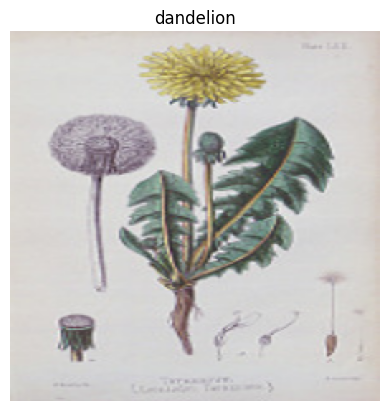

In [61]:
torch.manual_seed(42)

# Get a batch of images
image_batch, label_batch = next(iter(train_dataloader))

# Get a single image from the batch
image, label = image_batch[0], label_batch[0]

# View the batch shapes
print("Batch shape:",image.shape, label)

# Plot image with matplotlib
plt.imshow(image.permute(1, 2, 0)) # rearrange image dimensions to suit matplotlib [color_channels, height, width] -> [height, width, color_channels]
plt.title(class_names[label])
plt.axis(False)

# 4. ViT replication

## 4.1. Patches

In this scenario, we are defining:
- Patch/tile sie of 16x16 pixels
- Height and width of 224 pixels
- Number of channels/bands of 3

In [62]:
# Create example values
height = 224 # H ("The training resolution is 224.")
width = 224 # W
color_channels = 3 # C
patch_size = 16 # P

# Calculate N (number of patches)
number_of_patches = int((height * width) / patch_size**2)
print(f"Number of patches (N) with image height (H={height}), width (W={width}) and patch size (P={patch_size}): {number_of_patches}")

Number of patches (N) with image height (H=224), width (W=224) and patch size (P=16): 196


Defining the shape for the embedding layer input and output

In [63]:
# Input shape (this is the size of a single image)
embedding_layer_input_shape = (height, width, color_channels)

# Output shape
embedding_layer_output_shape = (number_of_patches, patch_size**2 * color_channels)

print(f"Input shape (single 2D image): {embedding_layer_input_shape}")
print(f"Output shape (single 2D image flattened into patches): {embedding_layer_output_shape}")

Input shape (single 2D image): (224, 224, 3)
Output shape (single 2D image flattened into patches): (196, 768)


Now, we are just splitting the image for better understanding and visualization.

First, we get the first patch row of 16 pixels.

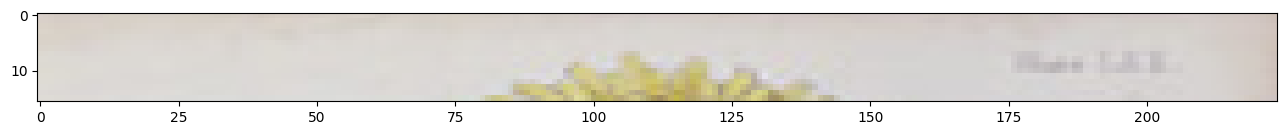

In [64]:
# Change image shape to be compatible with matplotlib (color_channels, height, width) -> (height, width, color_channels)
image_permuted = image.permute(1, 2, 0)

# Index to plot the top row of patched pixels
patch_size = 16
plt.figure(figsize=(patch_size, patch_size))
plt.imshow(image_permuted[:patch_size, :, :])

Now, we split it into columns with 16 pixels.

Number of patches per row: 14.0
Patch size: 16 pixels x 16 pixels


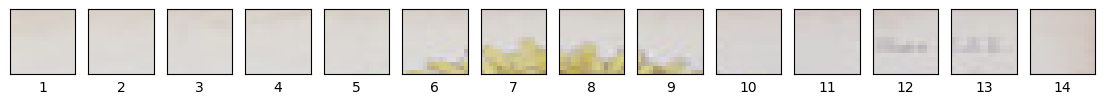

In [65]:
# Setup hyperparameters and make sure img_size and patch_size are compatible
img_size = 224
patch_size = 16
num_patches = img_size/patch_size
assert img_size % patch_size == 0, "Image size must be divisible by patch size"
print(f"Number of patches per row: {num_patches}\nPatch size: {patch_size} pixels x {patch_size} pixels")

# Create a series of subplots
fig, axs = plt.subplots(nrows=1,
                        ncols=img_size // patch_size, # one column for each patch
                        figsize=(num_patches, num_patches),
                        sharex=True,
                        sharey=True)

# Iterate through number of patches in the top row
for i, patch in enumerate(range(0, img_size, patch_size)):
    axs[i].imshow(image_permuted[:patch_size, patch:patch+patch_size, :]); # keep height index constant, alter the width index
    axs[i].set_xlabel(i+1) # set the label
    axs[i].set_xticks([])
    axs[i].set_yticks([])

Now we apply it for the entire image.

Number of patches per row: 14.0        
Number of patches per column: 14.0        
Total patches: 196.0        
Patch size: 16 pixels x 16 pixels


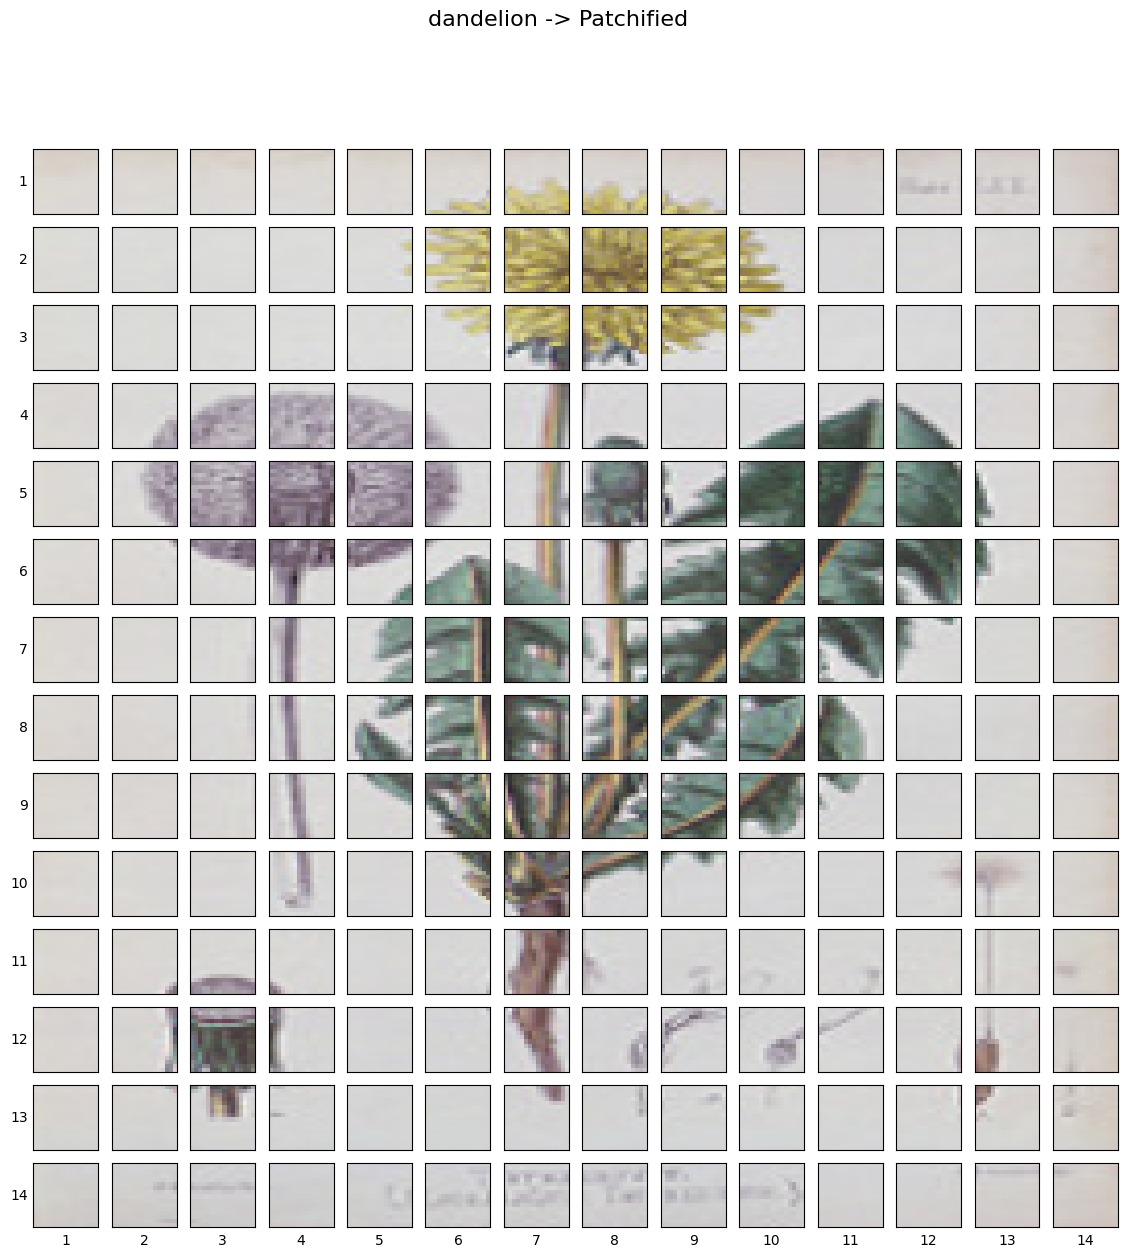

In [66]:
# Setup hyperparameters and make sure img_size and patch_size are compatible
img_size = 224
patch_size = 16
num_patches = img_size/patch_size
assert img_size % patch_size == 0, "Image size must be divisible by patch size"
print(f"Number of patches per row: {num_patches}\
        \nNumber of patches per column: {num_patches}\
        \nTotal patches: {num_patches*num_patches}\
        \nPatch size: {patch_size} pixels x {patch_size} pixels")

# Create a series of subplots
fig, axs = plt.subplots(nrows=img_size // patch_size, # need int not float
                        ncols=img_size // patch_size,
                        figsize=(num_patches, num_patches),
                        sharex=True,
                        sharey=True)

# Loop through height and width of image
for i, patch_height in enumerate(range(0, img_size, patch_size)): # iterate through height
    for j, patch_width in enumerate(range(0, img_size, patch_size)): # iterate through width

        # Plot the permuted image patch (image_permuted -> (Height, Width, Color Channels))
        axs[i, j].imshow(image_permuted[patch_height:patch_height+patch_size, # iterate through height
                                        patch_width:patch_width+patch_size, # iterate through width
                                        :]) # get all color channels

        # Set up label information, remove the ticks for clarity and set labels to outside
        axs[i, j].set_ylabel(i+1,
                             rotation="horizontal",
                             horizontalalignment="right",
                             verticalalignment="center")
        axs[i, j].set_xlabel(j+1)
        axs[i, j].set_xticks([])
        axs[i, j].set_yticks([])
        axs[i, j].label_outer()

# Set a super title
fig.suptitle(f"{class_names[label]} -> Patchified", fontsize=16)
plt.show()

Now, we will patchify the images with <code>torch.nn.Conv2D</code>

In [67]:
# Set the patch size
patch_size=16

# Create the Conv2d layer with hyperparameters from the ViT paper
conv2d = nn.Conv2d(in_channels=3, # number of color channels
                   out_channels=768, # Hidden size D, this is the embedding size
                   kernel_size=patch_size, # could also use (patch_size, patch_size)
                   stride=patch_size,
                   padding=0)

In [68]:
# Create flatten layer
flatten = nn.Flatten(start_dim=2, # flatten feature_map_height (dimension 2)
                     end_dim=3) # flatten feature_map_width (dimension 3)

Original image shape: torch.Size([3, 224, 224])
Image feature map shape: torch.Size([1, 768, 14, 14])
Flattened image feature map shape: torch.Size([1, 768, 196])


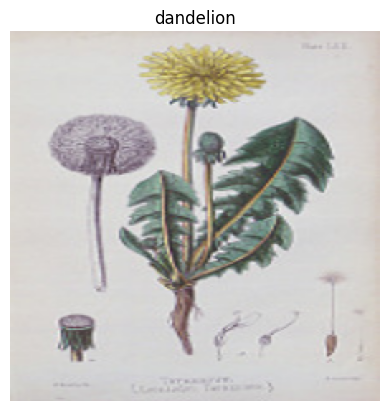

In [69]:
# 1. View single image
plt.imshow(image.permute(1, 2, 0)) # adjust for matplotlib
plt.title(class_names[label])
plt.axis(False)
print(f"Original image shape: {image.shape}")

# 2. Turn image into feature maps
image_out_of_conv = conv2d(image.unsqueeze(0)) # add batch dimension to avoid shape errors
print(f"Image feature map shape: {image_out_of_conv.shape}")

# 3. Flatten the feature maps
image_out_of_conv_flattened = flatten(image_out_of_conv)
print(f"Flattened image feature map shape: {image_out_of_conv_flattened.shape}")

## 4.2. Defining ViT classes

### 4.2.1. Creating the Patch Embedding Class

This class converts a 2D input image to a 1D embedded tensor.

In [70]:
# 1. Create a class which subclasses nn.Module
class PatchEmbedding(nn.Module):
    """Turns a 2D input image into a 1D sequence learnable embedding vector.

    Args:
        in_channels (int): Number of color channels for the input images. Defaults to 3.
        patch_size (int): Size of patches to convert input image into. Defaults to 16.
        embedding_dim (int): Size of embedding to turn image into. Defaults to 768.
        
    Returns:
        torch.Tensor: A tensor of shape (N, patch_size * patch_size * in_channels)
    """
    # 2. Initialize the class with appropriate variables
    def __init__(self,
                 in_channels:int=3,        # using 3 color channels for images
                 patch_size:int=16,        # using 16x16 patches as in the paper
                 embedding_dim:int=768):   # using 768 as the embedding dimension as in the paper
        
        super().__init__()

        # 3. Create a layer to turn an image into patches
        self.patcher = nn.Conv2d(in_channels=in_channels,     # number of color channels
                                 out_channels=embedding_dim,  # embedding size
                                 kernel_size=patch_size,      # patch size
                                 stride=patch_size,           # patch size
                                 padding=0)                   # no padding

        # 4. Create a layer to flatten the patch feature maps into a single dimension
        self.flatten = nn.Flatten(start_dim=2,  # only flatten the feature map dimensions into a single vector
                                  end_dim=3)    # don't flatten the batch dimension

    # 5. Define the forward method
    def forward(self, x):
        """
        Forward pass of the PatchEmbedding module.
        
        Args:
            x (torch.Tensor): A tensor of shape (B, C, H, W) where B is the batch size, C is the number of channels, H is the height and W is the width.
            
        Returns:
            torch.Tensor: A tensor of shape (B, N, E) where N is the number of patches and E is the embedding dimension.
        
        """
        # Create assertion to check that inputs are the correct shape
        image_resolution = x.shape[-1]
        assert image_resolution % patch_size == 0, f"Input image size must be divisible by patch size, image shape: {image_resolution}, patch size: {patch_size}"

        # Perform the forward pass
        x_patched = self.patcher(x)
        x_flattened = self.flatten(x_patched)
        # 6. Make sure the output shape has the right order
        return x_flattened.permute(0, 2, 1) # adjust so the embedding is on the final dimension [batch_size, P^2•C, N] -> [batch_size, N, P^2•C]

Now, we are applying the class to an image to test if it is working properly

In [71]:
set_seeds(42)

# Create an instance of patch embedding layer
patchify = PatchEmbedding(in_channels=3,
                          patch_size=16,
                          embedding_dim=768)

# Pass a single image through
print(f"Input image shape: {image.unsqueeze(0).shape}")
patch_embedded_image = patchify(image.unsqueeze(0)) # add an extra batch dimension on the 0th index, otherwise will error
print(f"Output patch embedding shape: {patch_embedded_image.shape}")

Input image shape: torch.Size([1, 3, 224, 224])
Output patch embedding shape: torch.Size([1, 196, 768])


In [72]:
set_seeds(42)

# 1. Set patch size
patch_size = 16

# 2. Print shape of original image tensor and get the image dimensions
print(f"Original image tensor shape: {image.shape}")
height, width = image.shape[1], image.shape[2]

# 3. Get image tensor and add batch dimension
x = image.unsqueeze(0)
print(f"Input image with batch dimension shape: {x.shape}")

# 4. Create patch embedding layer
patch_embedding_layer = PatchEmbedding(in_channels=3,
                                       patch_size=patch_size,
                                       embedding_dim=768)

# 5. Pass image through patch embedding layer
patch_embedding = patch_embedding_layer(x)
print(f"Patching embedding shape: {patch_embedding.shape}")

# 6. Create class token embedding
batch_size = patch_embedding.shape[0]
embedding_dimension = patch_embedding.shape[-1]
class_token = nn.Parameter(torch.ones(batch_size, 1, embedding_dimension),
                           requires_grad=True) # make sure it's learnable
print(f"Class token embedding shape: {class_token.shape}")

# 7. Prepend class token embedding to patch embedding
patch_embedding_class_token = torch.cat((class_token, patch_embedding), dim=1)
print(f"Patch embedding with class token shape: {patch_embedding_class_token.shape}")

# 8. Create position embedding
number_of_patches = int((height * width) / patch_size**2)
position_embedding = nn.Parameter(torch.ones(1, number_of_patches+1, embedding_dimension),
                                  requires_grad=True) # make sure it's learnable

# 9. Add position embedding to patch embedding with class token
patch_and_position_embedding = patch_embedding_class_token + position_embedding
print(f"Patch and position embedding shape: {patch_and_position_embedding.shape}")

Image tensor shape: torch.Size([3, 224, 224])
Input image with batch dimension shape: torch.Size([1, 3, 224, 224])
Patching embedding shape: torch.Size([1, 196, 768])
Class token embedding shape: torch.Size([1, 1, 768])
Patch embedding with class token shape: torch.Size([1, 197, 768])
Patch and position embedding shape: torch.Size([1, 197, 768])


### 4.2.2. Creating Multi-head Self Attention Class

In [73]:
# 1. Create a class that inherits from nn.Module
class MultiheadSelfAttentionBlock(nn.Module):
    """Creates a multi-head self-attention block ("MSA block" for short).
    
    Args:
        embedding_dim (int): The number of embedding dimensions.
        num_heads (int): The number of attention heads.
        attn_dropout (float): The amount of dropout to apply after the attention layer.
    
    Returns:
        torch.Tensor: A tensor of shape (B, N, E) where B is the batch size, N is the number of patches and E is the embedding dimension.
    """
    # 2. Initialize the class with hyperparameters from Table 1
    def __init__(self,
                 embedding_dim:int=768, # Hidden size D from Table 1 for ViT-Base
                 num_heads:int=12,      # Heads from Table 1 for ViT-Base
                 attn_dropout:float=0): # doesn't look like the paper uses any dropout in MSABlocks
        
        super().__init__()

        # 3. Create the Norm layer (LN)
        self.layer_norm = nn.LayerNorm(normalized_shape=embedding_dim)

        # 4. Create the Multi-Head Attention (MSA) layer
        self.multihead_attn = nn.MultiheadAttention(embed_dim=embedding_dim,
                                                    num_heads=num_heads,
                                                    dropout=attn_dropout,
                                                    batch_first=True) # does our batch dimension come first?

    # 5. Create a forward() method to pass the data through the layers
    def forward(self, x):
        """
        Forward pass of the MultiheadSelfAttentionBlock module.
        
        Args:
            x (torch.Tensor): A tensor of shape (B, N, E) where B is the batch size, N is the number of patches and E is the embedding dimension.
            
        Returns:
            torch.Tensor: A tensor of shape (B, N, E) where B is the batch size, N is the number of patches and E is the embedding dimension.
        """
        x = self.layer_norm(x)
        attn_output, _ = self.multihead_attn(query=x,            # query embeddings
                                             key=x,              # key embeddings
                                             value=x,            # value embeddings
                                             need_weights=False) # do we need the weights or just the layer outputs?
        return attn_output

Now we create this block and test its input and output size

In [74]:
# Create an instance of MSABlock
multihead_self_attention_block = MultiheadSelfAttentionBlock(embedding_dim=768, # from Table 1
                                                             num_heads=12) # from Table 1

# Pass patch and position image embedding through MSABlock
patched_image_through_msa_block = multihead_self_attention_block(patch_and_position_embedding)
print(f"Input shape of MSA block: {patch_and_position_embedding.shape}")
print(f"Output shape MSA block: {patched_image_through_msa_block.shape}")

Input shape of MSA block: torch.Size([1, 197, 768])
Output shape MSA block: torch.Size([1, 197, 768])


### 4.2.3. Creating Multilayer Perceptron Blocks

In [75]:
# 1. Create a class that inherits from nn.Module
class MLPBlock(nn.Module):
    """Creates a layer normalized multilayer perceptron block ("MLP block" for short).
    
    Args:
        embedding_dim (int): The number of embedding dimensions.
        mlp_size (int): The size of the hidden layer in the MLP.
        dropout (float): The amount of dropout to apply after each dense layer.
        
    Returns:
        torch.Tensor: A tensor of shape (B, N, E) where B is the batch size, N is the number of patches and E is the embedding dimension.
    """
    # 2. Initialize the class with hyperparameters from Table 1 and Table 3
    def __init__(self,
                 embedding_dim:int=768, # Hidden Size D from Table 1 for ViT-Base
                 mlp_size:int=3072, # MLP size from Table 1 for ViT-Base
                 dropout:float=0.1): # Dropout from Table 3 for ViT-Base
        
        super().__init__()

        # 3. Create the Norm layer (LN)
        self.layer_norm = nn.LayerNorm(normalized_shape=embedding_dim)

        # 4. Create the Multilayer perceptron (MLP) layer(s)
        self.mlp = nn.Sequential(
            nn.Linear(in_features=embedding_dim,
                      out_features=mlp_size),
            nn.GELU(), # "The MLP contains two layers with a GELU non-linearity (section 3.1)."
            nn.Dropout(p=dropout),
            nn.Linear(in_features=mlp_size, # needs to take same in_features as out_features of layer above
                      out_features=embedding_dim), # take back to embedding_dim
            nn.Dropout(p=dropout) # "Dropout, when used, is applied after every dense layer.."
        )

    # 5. Create a forward() method to pass the data through the layers
    def forward(self, x):
        """
        Forward pass of the MLPBlock module.
        
        Args:
            x (torch.Tensor): A tensor of shape (B, N, E) where B is the batch size, N is the number of patches and E is the embedding dimension.
        
        Returns:
            torch.Tensor: A tensor of shape (B, N, E) where B is the batch size, N is the number of patches and E is the embedding dimension.
        """
        x = self.layer_norm(x)
        x = self.mlp(x)
        return x

Creating the instance MLPblock

In [76]:
# Create an instance of MLPBlock
mlp_block = MLPBlock(embedding_dim=768, # from Table 1
                     mlp_size=3072, # from Table 1
                     dropout=0.1) # from Table 3

# Pass output of MSABlock through MLPBlock
patched_image_through_mlp_block = mlp_block(patched_image_through_msa_block)
print(f"Input shape of MLP block: {patched_image_through_msa_block.shape}")
print(f"Output shape MLP block: {patched_image_through_mlp_block.shape}")

Input shape of MLP block: torch.Size([1, 197, 768])
Output shape MLP block: torch.Size([1, 197, 768])


### 4.2.4. Creating Transformer Encoder Block

In [79]:
# 1. Create a class that inherits from nn.Module
class TransformerEncoderBlock(nn.Module):
    """Creates a Transformer Encoder block.
    
    Args:
        embedding_dim (int): The number of embedding dimensions.
        num_heads (int): The number of attention heads.
        mlp_size (int): The size of the hidden layer in the MLP.
        mlp_dropout (float): The amount of dropout to apply after each dense layer in the MLP.
        attn_dropout (float): The amount of dropout to apply after the attention layer.
        
    Returns:
        torch.Tensor: A tensor of shape (B, N, E) where B is the batch size, N is the number of patches and E is the embedding dimension.
    """
    # 2. Initialize the class with hyperparameters from Table 1 and Table 3
    def __init__(self,
                 embedding_dim:int=768, # Hidden size D from Table 1 for ViT-Base
                 num_heads:int=12, # Heads from Table 1 for ViT-Base
                 mlp_size:int=3072, # MLP size from Table 1 for ViT-Base
                 mlp_dropout:float=0.1, # Amount of dropout for dense layers from Table 3 for ViT-Base
                 attn_dropout:float=0): # Amount of dropout for attention layers
        super().__init__()

        # 3. Create MSA block (equation 2)
        self.msa_block = MultiheadSelfAttentionBlock(embedding_dim=embedding_dim,
                                                     num_heads=num_heads,
                                                     attn_dropout=attn_dropout)

        # 4. Create MLP block (equation 3)
        self.mlp_block =  MLPBlock(embedding_dim=embedding_dim,
                                   mlp_size=mlp_size,
                                   dropout=mlp_dropout)

    # 5. Create a forward() method
    def forward(self, x):

        # 6. Create residual connection for MSA block (add the input to the output)
        x =  self.msa_block(x) + x

        # 7. Create residual connection for MLP block (add the input to the output)
        x = self.mlp_block(x) + x

        return x

Creating the transformer block and plotting its layer summary

In [80]:
# Create an instance of TransformerEncoderBlock
transformer_encoder_block = TransformerEncoderBlock()

# # Print an input and output summary of our Transformer Encoder (uncomment for full output)
summary(model=transformer_encoder_block,
         input_size=(1, 197, 768), # (batch_size, num_patches, embedding_dimension)
         col_names=["input_size", "output_size", "num_params", "trainable"],
         col_width=20,
         row_settings=["var_names"])

Layer (type (var_name))                            Input Shape          Output Shape         Param #              Trainable
TransformerEncoderBlock (TransformerEncoderBlock)  [1, 197, 768]        [1, 197, 768]        --                   True
├─MultiheadSelfAttentionBlock (msa_block)          [1, 197, 768]        [1, 197, 768]        --                   True
│    └─LayerNorm (layer_norm)                      [1, 197, 768]        [1, 197, 768]        1,536                True
│    └─MultiheadAttention (multihead_attn)         --                   [1, 197, 768]        2,362,368            True
├─MLPBlock (mlp_block)                             [1, 197, 768]        [1, 197, 768]        --                   True
│    └─LayerNorm (layer_norm)                      [1, 197, 768]        [1, 197, 768]        1,536                True
│    └─Sequential (mlp)                            [1, 197, 768]        [1, 197, 768]        --                   True
│    │    └─Linear (0)                     

In [81]:
# Create the same as above with torch.nn.TransformerEncoderLayer()
torch_transformer_encoder_layer = nn.TransformerEncoderLayer(d_model=768, # Hidden size D from Table 1 for ViT-Base
                                                             nhead=12, # Heads from Table 1 for ViT-Base
                                                             dim_feedforward=3072, # MLP size from Table 1 for ViT-Base
                                                             dropout=0.1, # Amount of dropout for dense layers from Table 3 for ViT-Base
                                                             activation="gelu", # GELU non-linear activation
                                                             batch_first=True, # Do our batches come first?
                                                             norm_first=True) # Normalize first or after MSA/MLP layers?

torch_transformer_encoder_layer

TransformerEncoderLayer(
  (self_attn): MultiheadAttention(
    (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
  )
  (linear1): Linear(in_features=768, out_features=3072, bias=True)
  (dropout): Dropout(p=0.1, inplace=False)
  (linear2): Linear(in_features=3072, out_features=768, bias=True)
  (norm1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  (norm2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  (dropout1): Dropout(p=0.1, inplace=False)
  (dropout2): Dropout(p=0.1, inplace=False)
)

In [82]:
# # Get the output of PyTorch's version of the Transformer Encoder (uncomment for full output)
summary(model=torch_transformer_encoder_layer,
        input_size=(1, 197, 768), # (batch_size, num_patches, embedding_dimension)
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                            Input Shape          Output Shape         Param #              Trainable
TransformerEncoderLayer (TransformerEncoderLayer)  [1, 197, 768]        [1, 197, 768]        --                   True
├─LayerNorm (norm1)                                [1, 197, 768]        [1, 197, 768]        1,536                True
├─MultiheadAttention (self_attn)                   [1, 197, 768]        [1, 197, 768]        2,362,368            True
├─Dropout (dropout1)                               [1, 197, 768]        [1, 197, 768]        --                   --
├─LayerNorm (norm2)                                [1, 197, 768]        [1, 197, 768]        1,536                True
├─Linear (linear1)                                 [1, 197, 768]        [1, 197, 3072]       2,362,368            True
├─Dropout (dropout)                                [1, 197, 3072]       [1, 197, 3072]       --                   --
├─Linear (linear2)                             

### 4.2.5. Combining classes for Vit

In [83]:
# 1. Create a ViT class that inherits from nn.Module
class ViT(nn.Module):

    """Creates a Vision Transformer architecture with ViT-Base hyperparameters by default.
    
    Args:
        img_size (int): The size of the input image. Defaults to 224.
        in_channels (int): The number of input channels. Defaults to 3.
        patch_size (int): The size of the patches. Defaults to 16.
        num_transformer_layers (int): The number of transformer layers. Defaults to 12.
        embedding_dim (int): The embedding dimension. Defaults to 768.
        mlp_size (int): The size of the hidden layer in the MLP. Defaults to 3072.
        num_heads (int): The number of attention heads. Defaults to 12.
        attn_dropout (float): The amount of dropout to apply after the attention layer. Defaults to 0.
        mlp_dropout (float): The amount of dropout to apply after each dense layer in the MLP. Defaults to 0.1.
        embedding_dropout (float): The amount of dropout to apply after the patch and position embeddings. Defaults to 0.1.
        num_classes (int): The number of output classes. Defaults to 1000.
        
    Returns:
        torch.Tensor: A tensor of shape (B, num_classes) where B is the batch size and num_classes is the number of output classes.
    """

    # 2. Initialize the class with hyperparameters from Table 1 and Table 3
    def __init__(self,
                 img_size:int = 224,            # Training resolution from Table 3 in ViT paper
                 in_channels:int = 3,           # Number of channels in input image
                 patch_size:int = 16,           # Patch size
                 num_transformer_layers:int=12, # Layers from Table 1 for ViT-Base
                 embedding_dim:int=768,         # Hidden size D from Table 1 for ViT-Base
                 mlp_size:int=3072,             # MLP size from Table 1 for ViT-Base
                 num_heads:int=12,              # Heads from Table 1 for ViT-Base
                 attn_dropout:float=0,          # Dropout for attention projection
                 mlp_dropout:float=0.1,         # Dropout for dense/MLP layers
                 embedding_dropout:float=0.1,   # Dropout for patch and position embeddings
                 num_classes:int=1000):         # Default for ImageNet but can customize this

        super().__init__() # don't forget the super().__init__()!

        # 3. Make the image size is divisible by the patch size
        assert img_size % patch_size == 0, f"Image size must be divisible by patch size, image size: {img_size}, patch size: {patch_size}."

        # 4. Calculate number of patches (height * width/patch^2)
        self.num_patches = (img_size * img_size) // patch_size**2

        # 5. Create learnable class embedding (needs to go at front of sequence of patch embeddings)
        self.class_embedding = nn.Parameter(data=torch.randn(1, 1, embedding_dim),
                                            requires_grad=True)

        # 6. Create learnable position embedding
        self.position_embedding = nn.Parameter(data=torch.randn(1, self.num_patches+1, embedding_dim),
                                               requires_grad=True)

        # 7. Create embedding dropout value
        self.embedding_dropout = nn.Dropout(p=embedding_dropout)

        # 8. Create patch embedding layer
        self.patch_embedding = PatchEmbedding(in_channels=in_channels,
                                              patch_size=patch_size,
                                              embedding_dim=embedding_dim)

        # 9. Create Transformer Encoder blocks (we can stack Transformer Encoder blocks using nn.Sequential())
        # Note: The "*" means "all"
        self.transformer_encoder = nn.Sequential(*[TransformerEncoderBlock(embedding_dim=embedding_dim,
                                                                            num_heads=num_heads,
                                                                            mlp_size=mlp_size,
                                                                            mlp_dropout=mlp_dropout) for _ in range(num_transformer_layers)])

        # 10. Create classifier head
        self.classifier = nn.Sequential(
            nn.LayerNorm(normalized_shape=embedding_dim),
            nn.Linear(in_features=embedding_dim,
                      out_features=num_classes)
        )

    # 11. Create a forward() method
    def forward(self, x):

        # 12. Get batch size
        batch_size = x.shape[0]

        # 13. Create class token embedding and expand it to match the batch size (equation 1)
        class_token = self.class_embedding.expand(batch_size, -1, -1) # "-1" means to infer the dimension (try this line on its own)

        # 14. Create patch embedding (equation 1)
        x = self.patch_embedding(x)

        # 15. Concat class embedding and patch embedding (equation 1)
        x = torch.cat((class_token, x), dim=1)

        # 16. Add position embedding to patch embedding (equation 1)
        x = self.position_embedding + x

        # 17. Run embedding dropout (Appendix B.1)
        x = self.embedding_dropout(x)

        # 18. Pass patch, position and class embedding through transformer encoder layers (equations 2 & 3)
        x = self.transformer_encoder(x)

        # 19. Put 0 index logit through classifier (equation 4)
        x = self.classifier(x[:, 0]) # run on each sample in a batch at 0 index

        return x

In [84]:
# Example of creating the class embedding and expanding over a batch dimension
batch_size = 32
class_token_embedding_single = nn.Parameter(data=torch.randn(1, 1, 768)) # create a single learnable class token
class_token_embedding_expanded = class_token_embedding_single.expand(batch_size, -1, -1) # expand the single learnable class token across the batch dimension, "-1" means to "infer the dimension"

# Print out the change in shapes
print(f"Shape of class token embedding single: {class_token_embedding_single.shape}")
print(f"Shape of class token embedding expanded: {class_token_embedding_expanded.shape}")

Shape of class token embedding single: torch.Size([1, 1, 768])
Shape of class token embedding expanded: torch.Size([32, 1, 768])


Creating the ViT variable for training the data

In [85]:
set_seeds()

# Create a random tensor with same shape as a single image
random_image_tensor = torch.randn(1, 3, 224, 224) # (batch_size, color_channels, height, width)

# Create an instance of ViT with the number of classes we're working with (pizza, steak, sushi)
vit = ViT(num_classes=len(class_names))

# Pass the random image tensor to our ViT instance
vit(random_image_tensor)

tensor([[ 0.1234,  0.8412,  1.3322, -0.1883, -0.4334]],
       grad_fn=<AddmmBackward0>)

In [86]:
from torchinfo import summary

# # Print a summary of our custom ViT model using torchinfo (uncomment for actual output)
summary(model=vit,
        input_size=(32, 3, 224, 224), # (batch_size, color_channels, height, width)
        # col_names=["input_size"], # uncomment for smaller output
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
ViT (ViT)                                                    [32, 3, 224, 224]    [32, 5]              152,064              True
├─PatchEmbedding (patch_embedding)                           [32, 3, 224, 224]    [32, 196, 768]       --                   True
│    └─Conv2d (patcher)                                      [32, 3, 224, 224]    [32, 768, 14, 14]    590,592              True
│    └─Flatten (flatten)                                     [32, 768, 14, 14]    [32, 768, 196]       --                   --
├─Dropout (embedding_dropout)                                [32, 197, 768]       [32, 197, 768]       --                   --
├─Sequential (transformer_encoder)                           [32, 197, 768]       [32, 197, 768]       --                   True
│    └─TransformerEncoderBlock (0)                           [32, 197, 768]       [32, 197, 768]

## 4.3. Training Model

In [87]:
from going_modular.going_modular import engine
epochs = 20
learning_rate = 3e-3

# Setup the optimizer to optimize our ViT model parameters using hyperparameters from the ViT paper
optimizer = torch.optim.Adam(params=vit.parameters(),
                             lr=learning_rate, # Base LR from Table 3 for ViT-* ImageNet-1k
                             betas=(0.9, 0.999), # default values but also mentioned in ViT paper section 4.1 (Training & Fine-tuning)
                             weight_decay=0.3) # from the ViT paper section 4.1 (Training & Fine-tuning) and Table 3 for ViT-* ImageNet-1k

# Setup the loss function for multi-class classification
loss_fn = torch.nn.CrossEntropyLoss()

# Set the seeds
set_seeds()

# Train the model and save the training results to a dictionary
results = engine.train(model=vit,
                       train_dataloader=train_dataloader,
                       test_dataloader=test_dataloader,
                       optimizer=optimizer,
                       loss_fn=loss_fn,
                       epochs=epochs,
                       device=device)

  5%|▌         | 1/20 [01:48<34:21, 108.50s/it]

Epoch: 1 | train_loss: 2.0972 | train_acc: 0.2152 | test_loss: 1.7320 | test_acc: 0.2347


 10%|█         | 2/20 [03:36<32:32, 108.49s/it]

Epoch: 2 | train_loss: 1.6561 | train_acc: 0.2033 | test_loss: 1.6323 | test_acc: 0.2347


 15%|█▌        | 3/20 [05:29<31:14, 110.29s/it]

Epoch: 3 | train_loss: 1.6244 | train_acc: 0.2172 | test_loss: 1.6607 | test_acc: 0.2347


 20%|██        | 4/20 [07:17<29:09, 109.37s/it]

Epoch: 4 | train_loss: 1.6259 | train_acc: 0.2165 | test_loss: 1.6081 | test_acc: 0.2347


 25%|██▌       | 5/20 [09:04<27:09, 108.63s/it]

Epoch: 5 | train_loss: 1.6091 | train_acc: 0.2268 | test_loss: 1.6124 | test_acc: 0.1799


 30%|███       | 6/20 [10:52<25:17, 108.38s/it]

Epoch: 6 | train_loss: 1.6057 | train_acc: 0.2250 | test_loss: 1.6034 | test_acc: 0.2227


 35%|███▌      | 7/20 [12:40<23:26, 108.20s/it]

Epoch: 7 | train_loss: 1.6055 | train_acc: 0.2371 | test_loss: 1.6034 | test_acc: 0.2347


 40%|████      | 8/20 [14:29<21:40, 108.41s/it]

Epoch: 8 | train_loss: 1.6043 | train_acc: 0.2352 | test_loss: 1.6047 | test_acc: 0.2347


 45%|████▌     | 9/20 [16:16<19:48, 108.05s/it]

Epoch: 9 | train_loss: 1.6052 | train_acc: 0.2352 | test_loss: 1.6050 | test_acc: 0.2347


 50%|█████     | 10/20 [18:03<17:58, 107.85s/it]

Epoch: 10 | train_loss: 1.6053 | train_acc: 0.2350 | test_loss: 1.6050 | test_acc: 0.2347


 55%|█████▌    | 11/20 [19:56<16:22, 109.14s/it]

Epoch: 11 | train_loss: 1.6055 | train_acc: 0.2352 | test_loss: 1.6048 | test_acc: 0.2347


 60%|██████    | 12/20 [21:49<14:43, 110.41s/it]

Epoch: 12 | train_loss: 1.6054 | train_acc: 0.2352 | test_loss: 1.6052 | test_acc: 0.2347


 65%|██████▌   | 13/20 [23:43<13:00, 111.49s/it]

Epoch: 13 | train_loss: 1.6053 | train_acc: 0.2352 | test_loss: 1.6051 | test_acc: 0.2347


 70%|███████   | 14/20 [25:36<11:11, 111.99s/it]

Epoch: 14 | train_loss: 1.6055 | train_acc: 0.2353 | test_loss: 1.6049 | test_acc: 0.2347


 75%|███████▌  | 15/20 [27:32<09:26, 113.28s/it]

Epoch: 15 | train_loss: 1.6051 | train_acc: 0.2355 | test_loss: 1.6050 | test_acc: 0.2347


 80%|████████  | 16/20 [29:26<07:33, 113.48s/it]

Epoch: 16 | train_loss: 1.6053 | train_acc: 0.2352 | test_loss: 1.6050 | test_acc: 0.2347


 85%|████████▌ | 17/20 [31:21<05:41, 113.74s/it]

Epoch: 17 | train_loss: 1.6054 | train_acc: 0.2351 | test_loss: 1.6049 | test_acc: 0.2347


 90%|█████████ | 18/20 [33:17<03:49, 114.66s/it]

Epoch: 18 | train_loss: 1.6053 | train_acc: 0.2352 | test_loss: 1.6048 | test_acc: 0.2347


 95%|█████████▌| 19/20 [35:11<01:54, 114.43s/it]

Epoch: 19 | train_loss: 1.6051 | train_acc: 0.2355 | test_loss: 1.6045 | test_acc: 0.2347


100%|██████████| 20/20 [37:05<00:00, 111.28s/it]

Epoch: 20 | train_loss: 1.6044 | train_acc: 0.2349 | test_loss: 1.6050 | test_acc: 0.2347


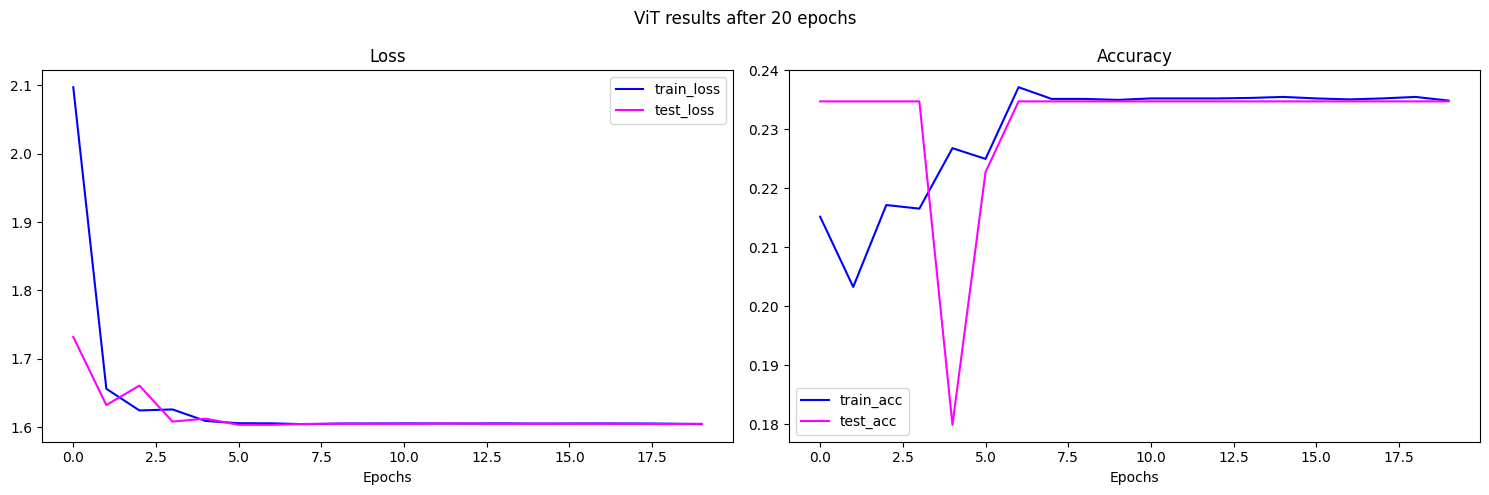

In [166]:
# Plot loss and accuracy curves
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

# Plot Loss
ax[0].plot(results["train_loss"], color='blue', label="train_loss")  # Blue line for train loss
ax[0].plot(results["test_loss"], color='magenta', label="test_loss")  # Orange line for test loss
ax[0].set_title("Loss")
ax[0].set_xlabel("Epochs")
ax[0].legend()

# Plot Accuracy
ax[1].plot(results["train_acc"], color='blue', label="train_acc")  # Green line for train accuracy
ax[1].plot(results["test_acc"], color='magenta', label="test_acc")      # Red line for test accuracy
ax[1].set_title("Accuracy")
ax[1].set_xlabel("Epochs")
ax[1].legend()

name_out = f"vit_results_{epochs}_epochs_{learning_rate}_lr_{BATCH_SIZE}_batch_size"

# Add a title to the overall plot
plt.suptitle(f"ViT results after {epochs} epochs")

# Save the model's state_dict()
plt.savefig(f"{name_out}.pdf", dpi=300, bbox_inches="tight")
plt.tight_layout()
plt.show()


## 4.4. Validation

In [154]:
validation_dir = "flowers_dataset2/validation"

# Create a dataloader for the validation data
validation_dataloader, _, _ = data_setup.create_dataloaders(train_dir=train_dir,
                                                          test_dir=validation_dir,
                                                          transform=manual_transforms,
                                                          batch_size=32)

In [155]:
import torch
from torch.utils.data import DataLoader

# Example validation function
def predict_validation_set(model, validation_loader, device):
    """
    Predict on the validation set using a PyTorch model.
    
    Args:
        model (torch.nn.Module): Trained PyTorch model.
        validation_loader (DataLoader): DataLoader for the validation set.
        device (torch.device): Device to run the model on (CPU or CUDA).
    
    Returns:
        predictions (list): List of model predictions.
        true_labels (list): List of true labels.
    """
    model.eval()  # Set the model to evaluation mode
    predictions = []
    true_labels = []

    with torch.no_grad():  # Disable gradient computation
        for inputs, labels in validation_loader:
            # Move inputs and labels to the device
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            # Forward pass
            outputs = model(inputs)
            
            # For classification tasks, get the predicted class
            _, preds = torch.max(outputs, 1)
            
            # Append predictions and true labels
            predictions.extend(preds.cpu().numpy())
            true_labels.extend(labels.cpu().numpy())
    
    return predictions, true_labels

# Example usage
# Assuming `model` is your trained PyTorch model, `validation_dataset` is your dataset

# Define the device (use GPU if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
vit.to(device)

# Call the function
predictions, true_labels = predict_validation_set(vit, validation_dataloader, device)

# Print a few results
print("Predictions:", predictions[:10])
print("True Labels:", true_labels[:10])


Predictions: [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
True Labels: [2, 1, 0, 3, 4, 0, 3, 3, 1, 1]


In [156]:
# Create confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Create confusion matrix
cm = confusion_matrix(true_labels, predictions)


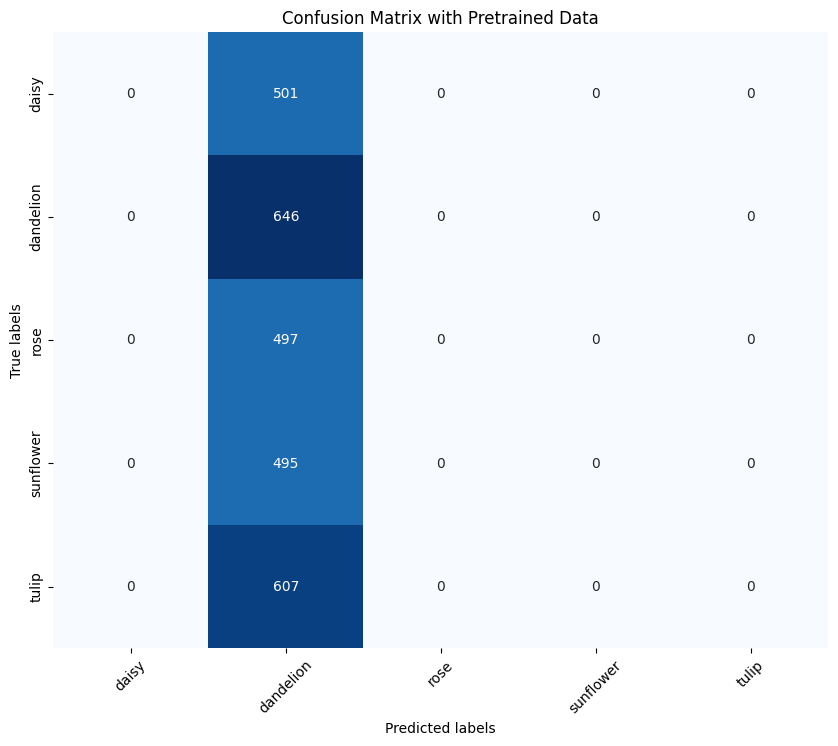

In [158]:
# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted labels")
plt.ylabel("True labels")
plt.title("Confusion Matrix with Pretrained Data")

plt.xticks(rotation=45)

name_out = f"vit_confusion_matrix.pdf"
plt.savefig(f"{name_out}", dpi=300, bbox_inches="tight")

plt.show()

In [159]:
# Get overall accuracy, F-1 score and Kappa
from sklearn.metrics import accuracy_score, f1_score, cohen_kappa_score

# Calculate accuracy
accuracy = accuracy_score(true_labels, predictions)

# Calculate F-1 score
f1 = f1_score(true_labels, predictions, average="weighted")

# Calculate Kappa
kappa = cohen_kappa_score(true_labels, predictions)

# Print results
print(f"Accuracy: {accuracy:.2f}")
print(f"F-1 Score: {f1:.2f}")
print(f"Cohen's Kappa: {kappa:.2f}")

Accuracy: 0.24
F-1 Score: 0.09
Cohen's Kappa: 0.00


# 5. Using pre-trained models

In [92]:
# The following requires torch v0.12+ and torchvision v0.13+
import torch
import torchvision
print(torch.__version__)
print(torchvision.__version__)

2.5.1+cu121
0.20.1+cu121


In [93]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [94]:
# 1. Get pretrained weights for ViT-Base
pretrained_vit_weights = torchvision.models.ViT_B_16_Weights.DEFAULT # requires torchvision >= 0.13, "DEFAULT" means best available

# 2. Setup a ViT model instance with pretrained weights
pretrained_vit = torchvision.models.vit_b_16(weights=pretrained_vit_weights).to(device)

# 3. Freeze the base parameters
for parameter in pretrained_vit.parameters():
    parameter.requires_grad = False

# 4. Change the classifier head (set the seeds to ensure same initialization with linear head)
set_seeds()
pretrained_vit.heads = nn.Linear(in_features=768, out_features=len(class_names)).to(device)
# pretrained_vit # uncomment for model output

Downloading: "https://download.pytorch.org/models/vit_b_16-c867db91.pth" to /home/sabrina/.cache/torch/hub/checkpoints/vit_b_16-c867db91.pth
100%|██████████| 330M/330M [00:10<00:00, 32.8MB/s] 


In [95]:
# # Print a summary using torchinfo (uncomment for actual output)
summary(model=pretrained_vit,
        input_size=(32, 3, 224, 224), # (batch_size, color_channels, height, width)
        # col_names=["input_size"], # uncomment for smaller output
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
VisionTransformer (VisionTransformer)                        [32, 3, 224, 224]    [32, 5]              768                  Partial
├─Conv2d (conv_proj)                                         [32, 3, 224, 224]    [32, 768, 14, 14]    (590,592)            False
├─Encoder (encoder)                                          [32, 197, 768]       [32, 197, 768]       151,296              False
│    └─Dropout (dropout)                                     [32, 197, 768]       [32, 197, 768]       --                   --
│    └─Sequential (layers)                                   [32, 197, 768]       [32, 197, 768]       --                   False
│    │    └─EncoderBlock (encoder_layer_0)                   [32, 197, 768]       [32, 197, 768]       (7,087,872)          False
│    │    └─EncoderBlock (encoder_layer_1)                   [32, 197, 768]       [32, 

In [96]:
# Setup train and test directory paths

train_dir, test_dir

(PosixPath('flowers_dataset/train'), PosixPath('flowers_dataset/train'))

In [97]:
# Get automatic transforms from pretrained ViT weights
pretrained_vit_transforms = pretrained_vit_weights.transforms()
print(pretrained_vit_transforms)

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)


In [98]:
# Setup dataloaders
train_dataloader_pretrained, test_dataloader_pretrained, class_names = data_setup.create_dataloaders(train_dir=train_dir,
                                                                                                     test_dir=test_dir,
                                                                                                     transform=pretrained_vit_transforms,
                                                                                                     batch_size=32) # Could increase if we had more samples, such as here: https://arxiv.org/abs/2205.01580 (there are other improvements there too...)


In [167]:
from going_modular.going_modular import engine

# Create optimizer and loss function
optimizer = torch.optim.Adam(params=pretrained_vit.parameters(),
                             lr=1e-3)
loss_fn = torch.nn.CrossEntropyLoss()

# Train the classifier head of the pretrained ViT feature extractor model
set_seeds()
pretrained_vit_results = engine.train(model=pretrained_vit,
                                      train_dataloader=train_dataloader_pretrained,
                                      test_dataloader=test_dataloader_pretrained,
                                      optimizer=optimizer,
                                      loss_fn=loss_fn,
                                      epochs=10,
                                      device=device)

 10%|█         | 1/10 [01:05<09:48, 65.41s/it]

Epoch: 1 | train_loss: 0.0798 | train_acc: 0.9840 | test_loss: 0.0637 | test_acc: 0.9891


 20%|██        | 2/10 [02:10<08:43, 65.49s/it]

Epoch: 2 | train_loss: 0.0668 | train_acc: 0.9873 | test_loss: 0.0574 | test_acc: 0.9927


 30%|███       | 3/10 [03:16<07:38, 65.55s/it]

Epoch: 3 | train_loss: 0.0591 | train_acc: 0.9902 | test_loss: 0.0486 | test_acc: 0.9935


 40%|████      | 4/10 [04:21<06:31, 65.29s/it]

Epoch: 4 | train_loss: 0.0525 | train_acc: 0.9924 | test_loss: 0.0432 | test_acc: 0.9945


 50%|█████     | 5/10 [05:26<05:26, 65.34s/it]

Epoch: 5 | train_loss: 0.0465 | train_acc: 0.9931 | test_loss: 0.0400 | test_acc: 0.9949


 60%|██████    | 6/10 [06:32<04:22, 65.53s/it]

Epoch: 6 | train_loss: 0.0420 | train_acc: 0.9930 | test_loss: 0.0359 | test_acc: 0.9964


 70%|███████   | 7/10 [07:36<03:15, 65.08s/it]

Epoch: 7 | train_loss: 0.0375 | train_acc: 0.9956 | test_loss: 0.0325 | test_acc: 0.9971


 80%|████████  | 8/10 [08:42<02:10, 65.37s/it]

Epoch: 8 | train_loss: 0.0348 | train_acc: 0.9964 | test_loss: 0.0348 | test_acc: 0.9941


 90%|█████████ | 9/10 [09:49<01:05, 65.59s/it]

Epoch: 9 | train_loss: 0.0321 | train_acc: 0.9964 | test_loss: 0.0273 | test_acc: 0.9982


100%|██████████| 10/10 [10:56<00:00, 65.62s/it]

Epoch: 10 | train_loss: 0.0289 | train_acc: 0.9971 | test_loss: 0.0249 | test_acc: 0.9989


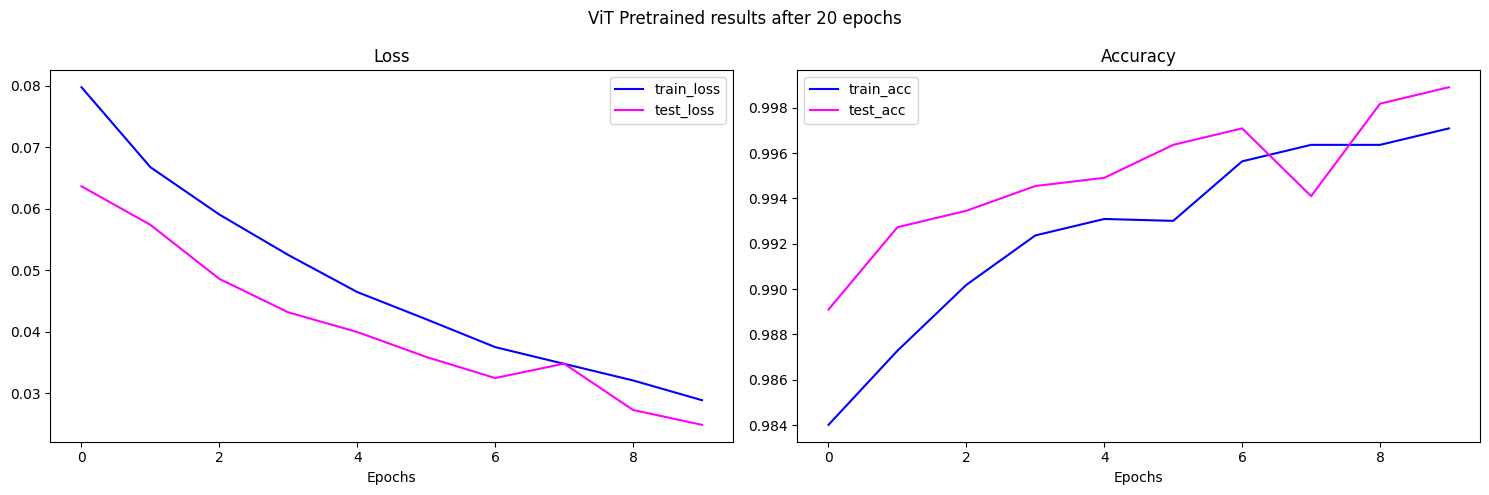

In [169]:
# Plot loss and accuracy curves
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

# Plot Loss
ax[0].plot(pretrained_vit_results["train_loss"], color='blue', label="train_loss")  # Blue line for train loss
ax[0].plot(pretrained_vit_results["test_loss"], color='magenta', label="test_loss")  # Orange line for test loss
ax[0].set_title("Loss")
ax[0].set_xlabel("Epochs")
ax[0].legend()

# Plot Accuracy
ax[1].plot(pretrained_vit_results["train_acc"], color='blue', label="train_acc")  # Green line for train accuracy
ax[1].plot(pretrained_vit_results["test_acc"], color='magenta', label="test_acc")      # Red line for test accuracy
ax[1].set_title("Accuracy")
ax[1].set_xlabel("Epochs")
ax[1].legend()

name_out = f"vit_pretrainedresults_{epochs}_epochs_{learning_rate}_lr_{BATCH_SIZE}_batch_size"

# Add a title to the overall plot
plt.suptitle(f"ViT Pretrained results after {epochs} epochs")

# Save the model's state_dict()
plt.savefig(f"{name_out}.pdf", dpi=300, bbox_inches="tight")
plt.tight_layout()
plt.show()


In [170]:
# Save the model
from going_modular.going_modular import utils

utils.save_model(model=pretrained_vit,
                 target_dir="models",
                 model_name="08_pretrained_vit_feature_extractor_flowers.pth")

[INFO] Saving model to: models/08_pretrained_vit_feature_extractor_flowers.pth


## 5.1. Predictions on a custom image

In [171]:
import requests
import random

# Import function to make predictions on images and plot them
from going_modular.going_modular.predictions import pred_and_plot_image

Found 1501 images:


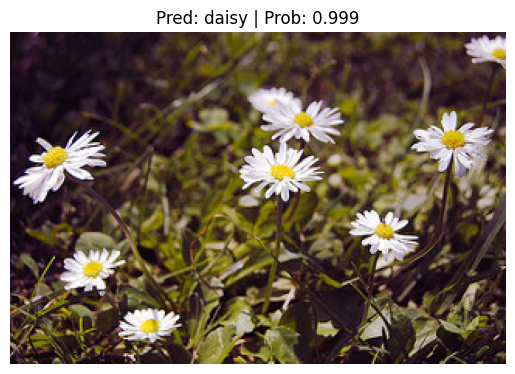

In [172]:
# Set seed
set_seeds(999)

# Setup custom image path
custom_image_path = Path("flowers_dataset2/validation")

images = list(custom_image_path.rglob("*/*.jpg"))

# Select a random image
random_image_path = random.choice(images)

# Example usage

print(f"Found {len(images)} images:")

# Predict on custom image
pred_and_plot_image(model=pretrained_vit,
                    image_path=random_image_path,
                    class_names=class_names)

## 5.2. Pretrained Validation

In [173]:
validation_dir = "flowers_dataset2/validation"

# Create a dataloader for the validation data
validation_dataloader, _, _ = data_setup.create_dataloaders(train_dir=train_dir,
                                                          test_dir=validation_dir,
                                                          transform=manual_transforms,
                                                          batch_size=32)

In [174]:
import torch
from torch.utils.data import DataLoader

# Example validation function
def predict_validation_set(model, validation_loader, device):
    """
    Predict on the validation set using a PyTorch model.
    
    Args:
        model (torch.nn.Module): Trained PyTorch model.
        validation_loader (DataLoader): DataLoader for the validation set.
        device (torch.device): Device to run the model on (CPU or CUDA).
    
    Returns:
        predictions (list): List of model predictions.
        true_labels (list): List of true labels.
    """
    model.eval()  # Set the model to evaluation mode
    predictions = []
    true_labels = []

    with torch.no_grad():  # Disable gradient computation
        for inputs, labels in validation_loader:
            # Move inputs and labels to the device
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            # Forward pass
            outputs = model(inputs)
            
            # For classification tasks, get the predicted class
            _, preds = torch.max(outputs, 1)
            
            # Append predictions and true labels
            predictions.extend(preds.cpu().numpy())
            true_labels.extend(labels.cpu().numpy())
    
    return predictions, true_labels

# Example usage
# Assuming `model` is your trained PyTorch model, `validation_dataset` is your dataset

# Define the device (use GPU if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
pretrained_vit.to(device)

# Call the function
predictions, true_labels = predict_validation_set(pretrained_vit, validation_dataloader, device)

# Print a few results
print("Predictions:", predictions[:10])
print("True Labels:", true_labels[:10])


Predictions: [2, 1, 3, 1, 2, 2, 2, 1, 2, 3]
True Labels: [4, 1, 3, 1, 4, 4, 2, 1, 2, 3]


In [175]:
# Create confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Create confusion matrix
cm = confusion_matrix(true_labels, predictions)


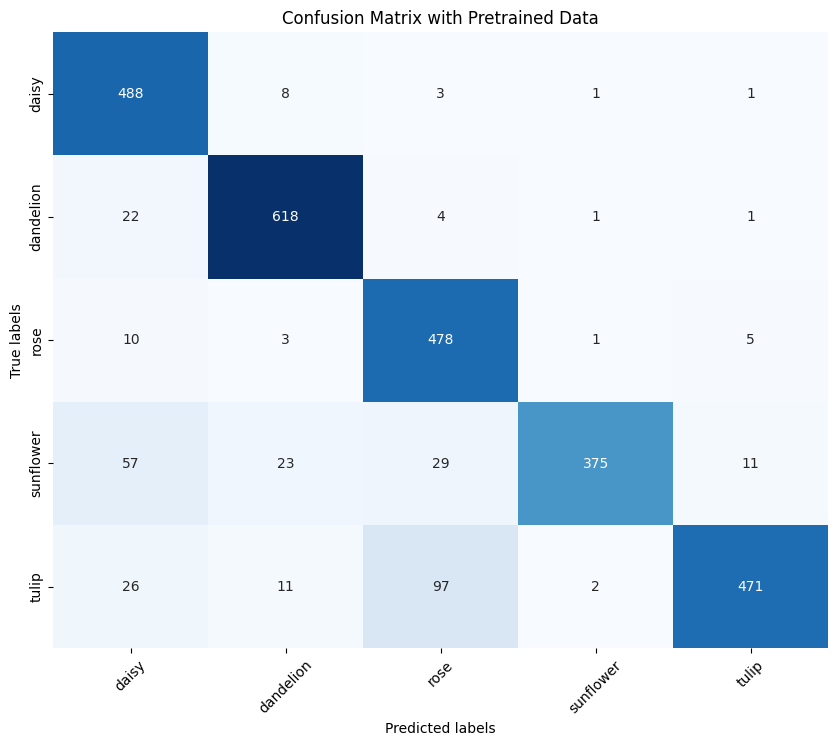

In [176]:
# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted labels")
plt.ylabel("True labels")
plt.title("Confusion Matrix with Pretrained Data")

plt.xticks(rotation=45)

name_out = f"vit_pretrained_confusion_matrix.pdf"
plt.savefig(f"{name_out}", dpi=300, bbox_inches="tight")

plt.show()

In [177]:
# Get overall accuracy, F-1 score and Kappa
from sklearn.metrics import accuracy_score, f1_score, cohen_kappa_score

# Calculate accuracy
accuracy = accuracy_score(true_labels, predictions)

# Calculate F-1 score
f1 = f1_score(true_labels, predictions, average="weighted")

# Calculate Kappa
kappa = cohen_kappa_score(true_labels, predictions)

# Print results
print(f"Accuracy: {accuracy:.2f}")
print(f"F-1 Score: {f1:.2f}")
print(f"Cohen's Kappa: {kappa:.2f}")

Accuracy: 0.88
F-1 Score: 0.88
Cohen's Kappa: 0.86
